In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from sklearn.linear_model import RidgeClassifierCV
import time
import numpy as np
from aeon.datasets import load_classification
sys.path.append(os.path.abspath("../code"))
from minirocket import fit, transform

# Load the published results to get dataset names
published = pd.read_csv('../results/results_ucr109_mean.csv')
dataset_names = published['dataset'].tolist()
print(f"{len(dataset_names)} datasets")

109 datasets


In [4]:
results = []

for name in dataset_names:
    try:
        X_train, y_train = load_classification(name, split="train")
        X_test, y_test = load_classification(name, split="test")
        X_train = X_train.squeeze().astype(np.float32)
        X_test = X_test.squeeze().astype(np.float32)
        
        t0 = time.time()
        parameters = fit(X_train)
        X_train_tf = transform(X_train, parameters)
        X_test_tf = transform(X_test, parameters)
        transform_time = time.time() - t0
        
        clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        clf.fit(X_train_tf, y_train)
        acc = clf.score(X_test_tf, y_test)
        
        results.append({
            'dataset': name,
            'accuracy': acc,
            'transform_time': transform_time
        })
        print(f"Work {name}: {acc:.4f} ({transform_time:.2f}s)")
    except Exception as e:
        print(f"Didn't work {name}: {e}")

results_df = pd.DataFrame(results)

Work ACSF1: 0.9000 (0.31s)
Work Adiac: 0.8261 (0.12s)
Work ArrowHead: 0.8857 (0.08s)
Work BME: 0.9867 (0.05s)
Work Beef: 0.8333 (0.07s)
Work BeetleFly: 0.9000 (0.07s)
Work BirdChicken: 0.9000 (0.07s)
Work CBF: 0.9989 (0.09s)
Work Car: 0.9000 (0.10s)
Work Chinatown: 0.9796 (0.04s)
Work ChlorineConcentration: 0.7516 (0.30s)
Work CinCECGTorso: 0.8022 (0.83s)
Work Coffee: 1.0000 (0.06s)
Work Computers: 0.7080 (0.18s)
Work CricketX: 0.8103 (0.13s)
Work CricketY: 0.7949 (0.14s)
Work CricketZ: 0.7846 (0.14s)
Work Crop: 0.7579 (0.89s)
Work DiatomSizeReduction: 0.9575 (0.13s)
Work DistalPhalanxOutlineAgeGroup: 0.7554 (0.05s)
Work DistalPhalanxOutlineCorrect: 0.7754 (0.06s)
Work DistalPhalanxTW: 0.6978 (0.05s)
Work ECG200: 0.9000 (0.04s)
Work ECG5000: 0.9456 (0.23s)
Work ECGFiveDays: 0.9977 (0.09s)
Work EOGHorizontalSignal: 0.5912 (0.27s)
Work EOGVerticalSignal: 0.5304 (0.28s)
Work Earthquakes: 0.7482 (0.11s)
Work ElectricDevices: 0.7378 (0.45s)
Work EthanolLevel: 0.5460 (0.53s)
Work FaceAll: 0.

In [5]:
published = pd.read_csv('../results/results_ucr109_mean.csv')
print(published.head())
print(published.columns.tolist())

     dataset  accuracy  time_training_seconds  time_test_seconds
0      ACSF1  0.822333                   0.49               0.25
1      Adiac  0.801705                   0.45               0.23
2  ArrowHead  0.880952                   0.13               0.14
3        BME  0.992222                   0.11               0.07
4       Beef  0.761111                   0.17               0.04
['dataset', 'accuracy', 'time_training_seconds', 'time_test_seconds']


In [6]:
# Merge results with published results
results_df = pd.DataFrame(results)
comparison = results_df.merge(published, on='dataset', suffixes=('_ours', '_published'))

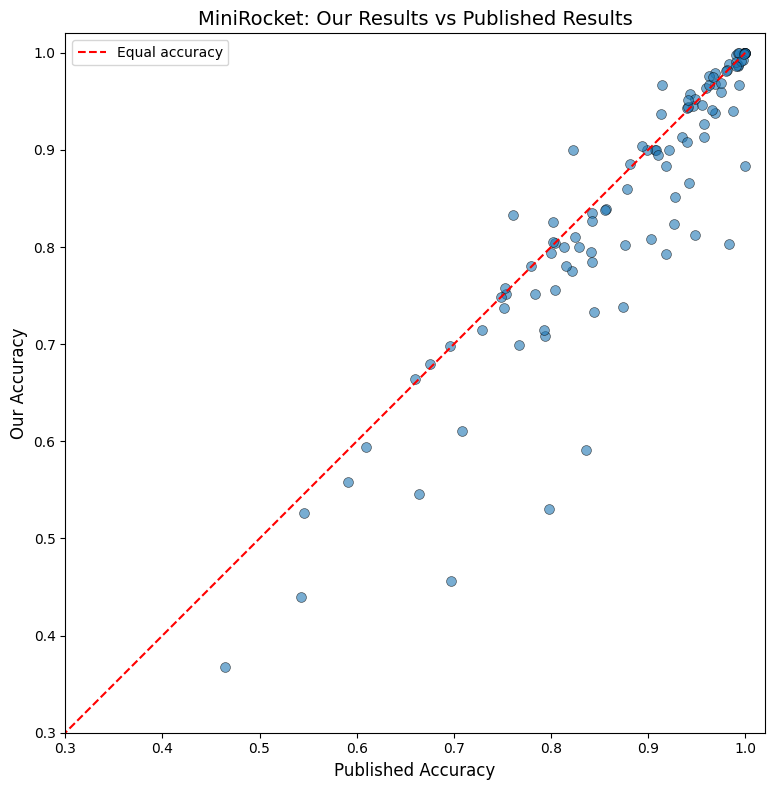

In [7]:
# Scatter plot: our accuracy vs published accuracy
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(comparison['accuracy_published'], comparison['accuracy_ours'], 
           alpha=0.6, edgecolors='black', linewidths=0.5, s=50)
ax.plot([0, 1], [0, 1], 'r--', label='Equal accuracy')
ax.set_xlabel('Published Accuracy', fontsize=12)
ax.set_ylabel('Our Accuracy', fontsize=12)
ax.set_title('MiniRocket: Our Results vs Published Results', fontsize=14)
ax.legend()
ax.set_xlim(0.3, 1.02)
ax.set_ylim(0.3, 1.02)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150)
plt.show()

In [8]:
# Summary statistics
better = (comparison['accuracy_ours'] > comparison['accuracy_published']).sum()
worse = (comparison['accuracy_ours'] < comparison['accuracy_published']).sum()
equal = (comparison['accuracy_ours'] == comparison['accuracy_published']).sum()

print(f"Our mean accuracy:       {comparison['accuracy_ours'].mean():.4f}")
print(f"Published mean accuracy: {comparison['accuracy_published'].mean():.4f}")
print(f"We are better on:  {better} datasets")
print(f"We are worse on:   {worse} datasets")
print(f"Equal on:          {equal} datasets")
print(f"Mean abs difference: {(comparison['accuracy_ours'] - comparison['accuracy_published']).abs().mean():.4f}")

Our mean accuracy:       0.8370
Published mean accuracy: 0.8724
We are better on:  34 datasets
We are worse on:   71 datasets
Equal on:          4 datasets
Mean abs difference: 0.0426


In [9]:
comparison['diff'] = comparison['accuracy_ours'] - comparison['accuracy_published']
print("Top 10 datasets where we differ most:")
print(comparison.nlargest(10, 'diff')[['dataset', 'accuracy_ours', 'accuracy_published', 'diff']])
print()
print("Top 10 datasets where published is better:")
print(comparison.nsmallest(10, 'diff')[['dataset', 'accuracy_ours', 'accuracy_published', 'diff']])

Top 10 datasets where we differ most:
                          dataset  accuracy_ours  accuracy_published      diff
0                           ACSF1       0.900000            0.822333  0.077667
4                            Beef       0.833333            0.761111  0.072222
65                       OliveOil       0.966667            0.914444  0.052223
1                           Adiac       0.826087            0.801705  0.024382
63                     MoteStrain       0.936901            0.912913  0.023988
18            DiatomSizeReduction       0.957516            0.942810  0.014706
69                 PigArtPressure       0.975962            0.962500  0.013462
93               ToeSegmentation1       0.951754            0.941082  0.010672
9                       Chinatown       0.979592            0.968999  0.010593
74  ProximalPhalanxOutlineCorrect       0.903780            0.894158  0.009622

Top 10 datasets where published is better:
                  dataset  accuracy_ours  accurac

In [14]:
# Save comparison results

comparison.to_csv(os.path.abspath("../results") + '/minirocket_comparison.csv', index=False)
results_df.to_csv(os.path.abspath("../results") + '/minirocket_results.csv', index=False)